In [24]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle


In [25]:
# Load dari URL atau unggah manual
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/pima-indians-diabetes.data.csv"
columns = ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin',
           'BMI', 'DiabetesPedigreeFunction', 'Age', 'Outcome']
df = pd.read_csv(url, names=columns)

df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [26]:
to_clean = ['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']
df[to_clean] = df[to_clean].replace(0, np.nan)
df.fillna(df.median(), inplace=True)

# Pisah fitur dan target
X = df.drop('Outcome', axis=1)
y = df['Outcome']

# Feature selection
selector = SelectKBest(score_func=f_classif, k=6)  # pilih 6 fitur terbaik
X_selected = selector.fit_transform(X, y)
selected_features = X.columns[selector.get_support()]
print("Fitur terbaik:", list(selected_features))

# Scaling
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

Fitur terbaik: ['Pregnancies', 'Glucose', 'SkinThickness', 'Insulin', 'BMI', 'Age']


In [27]:
# SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X_scaled, y)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [29]:
param_grid = {
    'n_neighbors': range(1, 21),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

print("Best Params:", grid.best_params_)
print("Best Accuracy (Train):", round(grid.best_score_ * 100, 2), "%")


Fitting 5 folds for each of 80 candidates, totalling 400 fits
Best Params: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
Best Accuracy (Train): 81.62 %


Akurasi Akhir (Test Set): 80.0 %


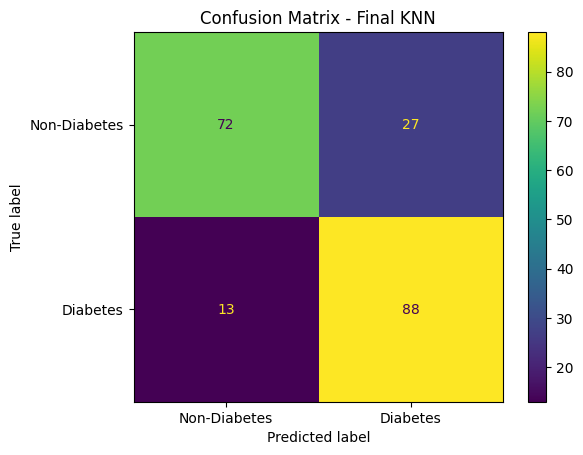

In [30]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Akurasi Akhir (Test Set):", round(acc * 100, 2), "%")

cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, display_labels=["Non-Diabetes", "Diabetes"]).plot()
plt.title("Confusion Matrix - Final KNN")
plt.show()


In [ ]:
with open("knn_best_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

with open("scaler_selected.pkl", "wb") as f:
    pickle.dump(scaler, f)

with open("features_selected.pkl", "wb") as f:
    pickle.dump(list(selected_features), f)
